In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.6f' % x) #为了直观的显示数字，不采用科学计数法
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import numpy as np
np.set_printoptions(suppress = True)
import scipy
import os
import math
import time
import random
import joblib
from joblib import Parallel, delayed
import warnings
from tqdm.notebook import tqdm
import gc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
try:
    physical_devices = tf.config.list_physical_devices('GPU') 
    print('GPUs: %s' % physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except Exception as e:
    print('貌似可能没有GPU')
tf.keras.backend.set_floatx('float32')

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data_folder = '../../preprocessed_data/final/'
folders = os.listdir(data_folder)
folders
base_types = ['4g', '5g']
kpis = ['PDCCH', 'PDCPDL', 'PDCPUL', 'PDSCH', 'PUSCH', 'RRC']

['5g_PDCPUL',
 '5g_PDSCH',
 '5g_RRC',
 '4g_PDCPDL',
 '4g_PDCPUL',
 '4g_RRC',
 '.ipynb_checkpoints',
 '4g_PDSCH',
 '5g_PDCPDL',
 '4g_PDCCH',
 '5g_PUSCH',
 '4g_PUSCH',
 '5g_PDCCH']

In [3]:
input_periods = 24 * 21
n_features = 28
input_cols = ['is_holiday_%s' % i for i in range(n_features)] + ['input_%s' % i for i in range(input_periods)]
output_periods = 24 * 7
output_cols = ['output_%s' % i for i in range(output_periods)]

def custom_mape(y_actual, y_pred):
    absolute_error = tf.abs(y_actual - y_pred)
    absolute_precentage_error = absolute_error / y_actual * 100.
    
    mean_by_row = tf.reshape(tf.reduce_mean(y_actual, axis=1), (-1, 1))
    unified_absolute_error = absolute_error / mean_by_row * 100.
    
    combined_error = tf.where(absolute_precentage_error <= 100., absolute_precentage_error, 2 * unified_absolute_error)
    return tf.reduce_mean(combined_error) ** 2

default_lr = 0.0005

def build_compile_model(loss, use_output_relu=False):
    input_ = keras.Input(shape=n_features + input_periods)
    mean_by_row = tf.reshape(tf.reduce_mean(input_[:, n_features:], axis=1), (-1, 1))
    normalized_input = tf.concat([input_[:, :n_features], input_[:, n_features:] / mean_by_row], axis=1)
    hidden_1 = tf.nn.relu(layers.Dense(4096, use_bias=True)(normalized_input))
    hidden_2 = tf.nn.relu(layers.Dense(4096, use_bias=True)(normalized_input) + layers.Dense(4096, use_bias=True)(hidden_1)) / 2.
    output = (layers.Dense(output_periods, use_bias=True)(normalized_input) + layers.Dense(output_periods, use_bias=True)(hidden_1)
              + layers.Dense(output_periods, use_bias=True)(hidden_2)) / 3.
    output *= mean_by_row
    if use_output_relu:
        output = tf.nn.relu(output)
    model = keras.Model(input_, output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=default_lr)
    model.compile(optimizer, loss)
    return model

# batch size和epochs
training_params = {
    'PDCCH': (8192, 128),
    'PDCPDL': (8192, 128),
    'PDCPUL': (16384, 128),
    'PDSCH': (8192, 128),
    'PUSCH': (8192, 128),
    'RRC': (8192, 128)
}

def train(model, folder, kpi):
    print('reading data')
    train_df = pd.read_pickle(os.path.join(folder, 'regression_train_data.pkl'))
    print('extracting training array')
    train_x, train_y = train_df.loc[:, input_cols].values.astype(np.float32), train_df.loc[:, output_cols].values.astype(np.float32)
    del train_df; gc.collect()
    batch_size, epochs = training_params[kpi]
    def scheduler(epoch, lr):
        return lr - default_lr / epochs
    callback = keras.callbacks.LearningRateScheduler(scheduler)
    model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, callbacks=[callback])
    del train_x, train_y; gc.collect()

In [4]:
for kpi in kpis:
    print('building model for %s' % kpi)
    model = build_compile_model(custom_mape, False)
    model.load_weights('models/4g_%s.h5' % kpi)
    print('training model for %s' % kpi)
    train(model, os.path.join(data_folder, '%s_%s' % ('5g', kpi)), kpi)
    print('saving model for %s' % kpi)
    model.save('models/5g_%s.h5' % kpi)
    del model; gc.collect() # 这个似乎是必须的。

building model for PDCCH
training model for PDCCH
reading data
extracting training array
Train on 130320 samples
Epoch 1/128
130320/130320 [==============================] - 3s 21us/sample - loss: 287.0339
Epoch 2/128
130320/130320 [==============================] - 1s 11us/sample - loss: 212.5923
Epoch 3/128
130320/130320 [==============================] - 1s 11us/sample - loss: 194.7690
Epoch 4/128
130320/130320 [==============================] - 1s 11us/sample - loss: 188.1860
Epoch 5/128
130320/130320 [==============================] - 1s 11us/sample - loss: 184.5455
Epoch 6/128
130320/130320 [==============================] - 1s 11us/sample - loss: 182.0434
Epoch 7/128
130320/130320 [==============================] - 1s 11us/sample - loss: 180.5186
Epoch 8/128
130320/130320 [==============================] - 1s 11us/sample - loss: 179.3280
Epoch 9/128
130320/130320 [==============================] - 1s 11us/sample - loss: 178.3600
Epoch 10/128
130320/130320 [======================

7888

building model for PDCPDL
training model for PDCPDL
reading data
extracting training array
Train on 130320 samples
Epoch 1/128
130320/130320 [==============================] - 2s 18us/sample - loss: 1109.1000
Epoch 2/128
130320/130320 [==============================] - 1s 11us/sample - loss: 944.8799
Epoch 3/128
130320/130320 [==============================] - 1s 11us/sample - loss: 900.7786
Epoch 4/128
130320/130320 [==============================] - 2s 12us/sample - loss: 884.2133
Epoch 5/128
130320/130320 [==============================] - 2s 13us/sample - loss: 878.1889
Epoch 6/128
130320/130320 [==============================] - 2s 12us/sample - loss: 871.9515
Epoch 7/128
130320/130320 [==============================] - 2s 12us/sample - loss: 872.8823
Epoch 8/128
130320/130320 [==============================] - 1s 11us/sample - loss: 865.5939
Epoch 9/128
130320/130320 [==============================] - 1s 11us/sample - loss: 860.4296
Epoch 10/128
130320/130320 [===================

7888

building model for PDCPUL
training model for PDCPUL
reading data
extracting training array
Train on 130260 samples
Epoch 1/128
130260/130260 [==============================] - 3s 20us/sample - loss: 2502.1303
Epoch 2/128
130260/130260 [==============================] - 1s 11us/sample - loss: 1525.0895
Epoch 3/128
130260/130260 [==============================] - 2s 12us/sample - loss: 1256.1088
Epoch 4/128
130260/130260 [==============================] - 2s 12us/sample - loss: 1111.8095
Epoch 5/128
130260/130260 [==============================] - 2s 12us/sample - loss: 1055.6697
Epoch 6/128
130260/130260 [==============================] - 2s 12us/sample - loss: 1017.0734
Epoch 7/128
130260/130260 [==============================] - 2s 12us/sample - loss: 1000.6135
Epoch 8/128
130260/130260 [==============================] - 2s 12us/sample - loss: 986.0766
Epoch 9/128
130260/130260 [==============================] - 2s 12us/sample - loss: 975.5949
Epoch 10/128
130260/130260 [=============

7888

building model for PDSCH
training model for PDSCH
reading data
extracting training array
Train on 130590 samples
Epoch 1/128
130590/130590 [==============================] - 2s 18us/sample - loss: 2073.3338
Epoch 2/128
130590/130590 [==============================] - 1s 11us/sample - loss: 401.2702
Epoch 3/128
130590/130590 [==============================] - 2s 11us/sample - loss: 330.2309
Epoch 4/128
130590/130590 [==============================] - 2s 12us/sample - loss: 304.4718
Epoch 5/128
130590/130590 [==============================] - 1s 11us/sample - loss: 291.4573
Epoch 6/128
130590/130590 [==============================] - 2s 12us/sample - loss: 282.9050
Epoch 7/128
130590/130590 [==============================] - 1s 11us/sample - loss: 276.5164
Epoch 8/128
130590/130590 [==============================] - 2s 12us/sample - loss: 271.4447
Epoch 9/128
130590/130590 [==============================] - 2s 11us/sample - loss: 267.8202
Epoch 10/128
130590/130590 [=====================

7888

building model for PUSCH
training model for PUSCH
reading data
extracting training array
Train on 130020 samples
Epoch 1/128
130020/130020 [==============================] - 2s 18us/sample - loss: 801.2342
Epoch 2/128
130020/130020 [==============================] - 1s 11us/sample - loss: 598.8023
Epoch 3/128
130020/130020 [==============================] - 1s 11us/sample - loss: 563.4541
Epoch 4/128
130020/130020 [==============================] - 1s 11us/sample - loss: 552.0715
Epoch 5/128
130020/130020 [==============================] - 1s 11us/sample - loss: 543.8334
Epoch 6/128
130020/130020 [==============================] - 1s 11us/sample - loss: 538.4243
Epoch 7/128
130020/130020 [==============================] - 1s 11us/sample - loss: 534.1928
Epoch 8/128
130020/130020 [==============================] - 1s 11us/sample - loss: 530.2466
Epoch 9/128
130020/130020 [==============================] - 1s 11us/sample - loss: 527.9035
Epoch 10/128
130020/130020 [======================

7888

building model for RRC
training model for RRC
reading data
extracting training array
Train on 130170 samples
Epoch 1/128
130170/130170 [==============================] - 2s 19us/sample - loss: 3249.1930
Epoch 2/128
130170/130170 [==============================] - 1s 11us/sample - loss: 723.3312
Epoch 3/128
130170/130170 [==============================] - 1s 11us/sample - loss: 461.1236
Epoch 4/128
130170/130170 [==============================] - 1s 11us/sample - loss: 406.7075
Epoch 5/128
130170/130170 [==============================] - 1s 11us/sample - loss: 377.9679
Epoch 6/128
130170/130170 [==============================] - 1s 11us/sample - loss: 359.9834
Epoch 7/128
130170/130170 [==============================] - 1s 11us/sample - loss: 348.3947
Epoch 8/128
130170/130170 [==============================] - 2s 12us/sample - loss: 340.1456
Epoch 9/128
130170/130170 [==============================] - 2s 12us/sample - loss: 332.5458
Epoch 10/128
130170/130170 [=========================

7888

---

In [5]:
def plot_result(model, folder):
    train_df = pd.read_pickle(os.path.join(folder, 'regression_train_data.pkl')).sample(5)
    train_x = train_df.loc[:, input_cols].values.astype(np.float32)
    train_y = train_df.loc[:, output_cols].values.astype(np.float32)
    train_x_y = train_df.loc[:, input_cols[n_features:] + output_cols].values.astype(np.float32)
    predict = model.predict(train_x)
    for i in range(5):
        print('MAPE: %s' % (keras.losses.MeanAbsolutePercentageError()(train_y[i], predict[i])))
        _ = plt.figure(figsize=(20, 3))
#         _ = plt.scatter(np.arange(input_periods + output_periods), train_x_y[i], s=4)
#         _ = plt.scatter(np.arange(input_periods, input_periods + output_periods), predict[i], s=4)
        _ = plt.plot(np.arange(input_periods + output_periods), train_x_y[i])
        _ = plt.plot(np.arange(input_periods, input_periods + output_periods), predict[i])
        _ = plt.show()

showing plots for kpi PDCCH
MAPE: tf.Tensor(6.6463785, shape=(), dtype=float32)


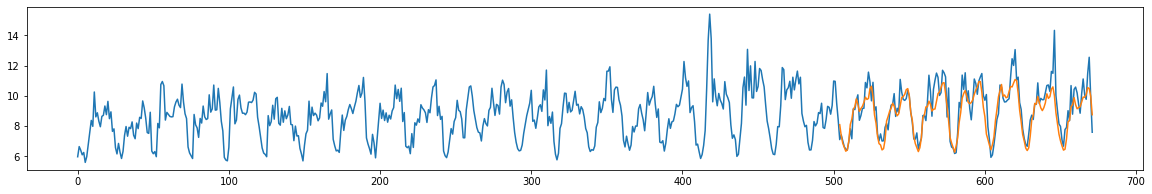

MAPE: tf.Tensor(6.443976, shape=(), dtype=float32)


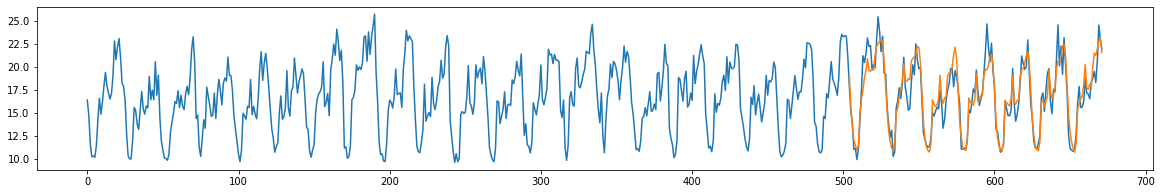

MAPE: tf.Tensor(8.071155, shape=(), dtype=float32)


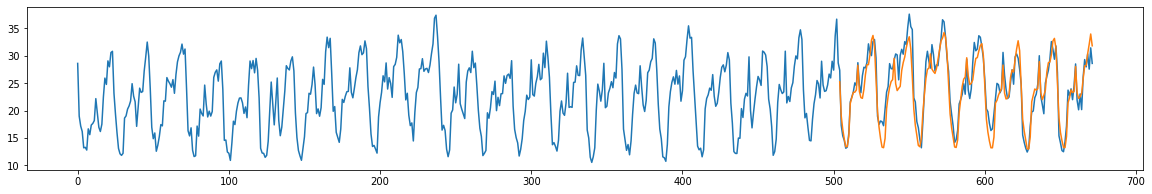

MAPE: tf.Tensor(18.912012, shape=(), dtype=float32)


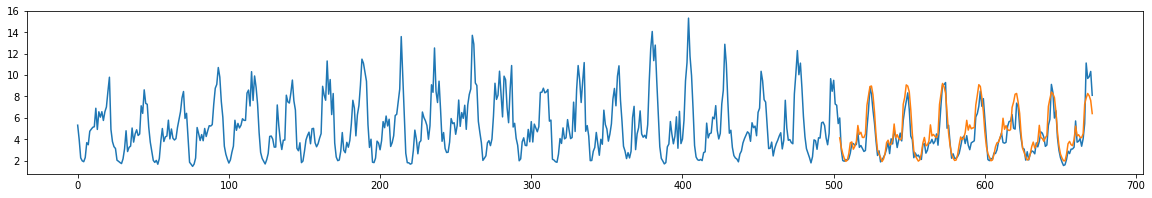

MAPE: tf.Tensor(3.9597166, shape=(), dtype=float32)


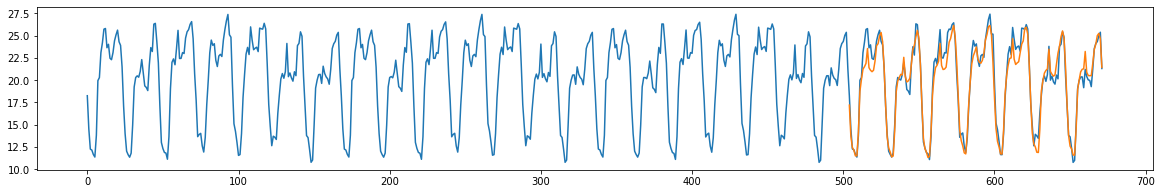

showing plots for kpi PDCPDL
MAPE: tf.Tensor(29.262253, shape=(), dtype=float32)


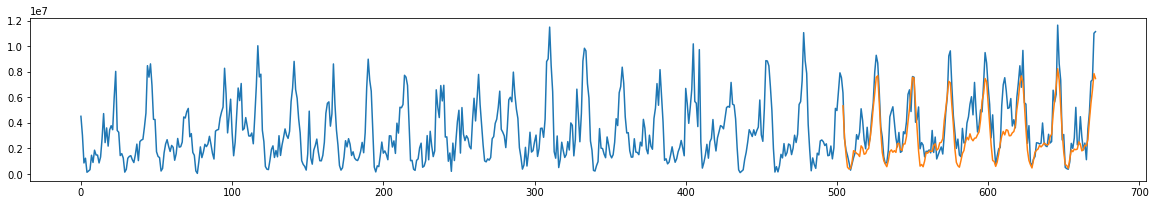

MAPE: tf.Tensor(17.649837, shape=(), dtype=float32)


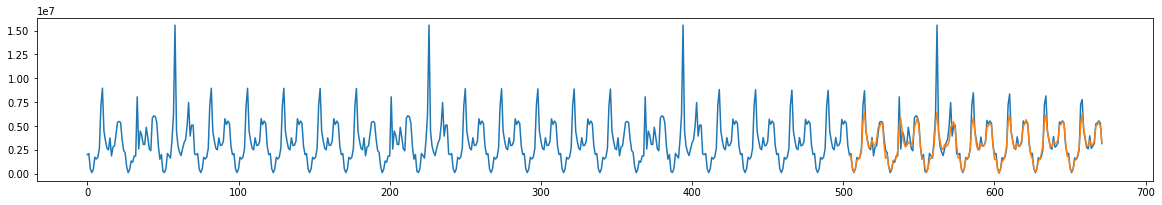

MAPE: tf.Tensor(28.113693, shape=(), dtype=float32)


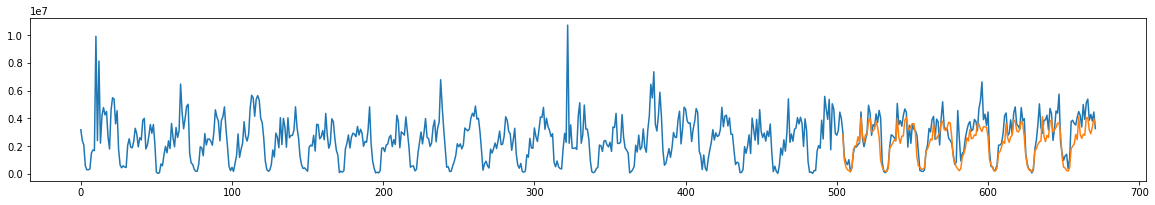

MAPE: tf.Tensor(27.312014, shape=(), dtype=float32)


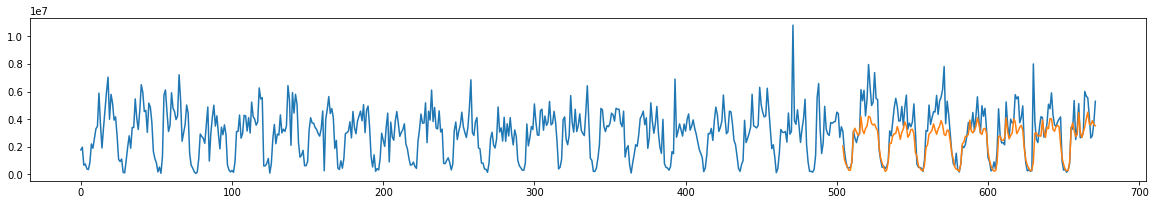

MAPE: tf.Tensor(27.410654, shape=(), dtype=float32)


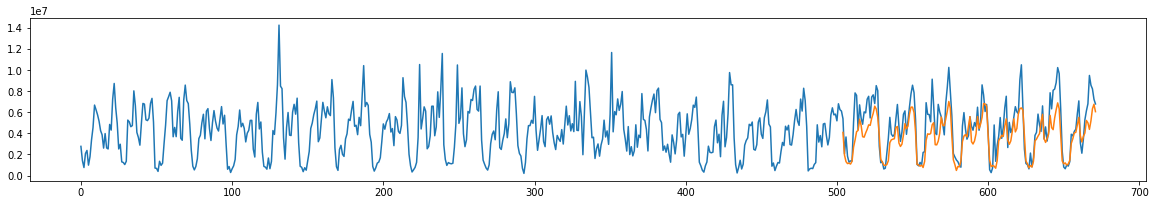

showing plots for kpi PDCPUL
MAPE: tf.Tensor(31.361452, shape=(), dtype=float32)


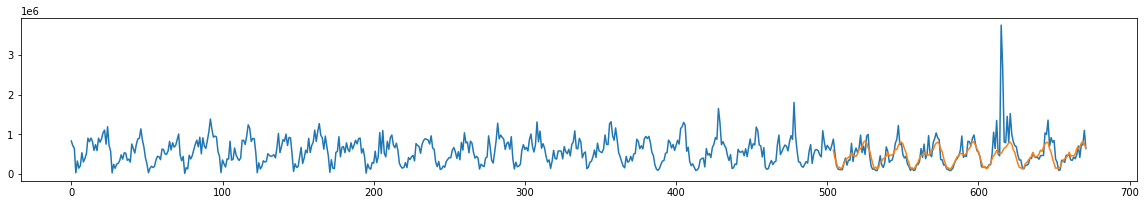

MAPE: tf.Tensor(28.786722, shape=(), dtype=float32)


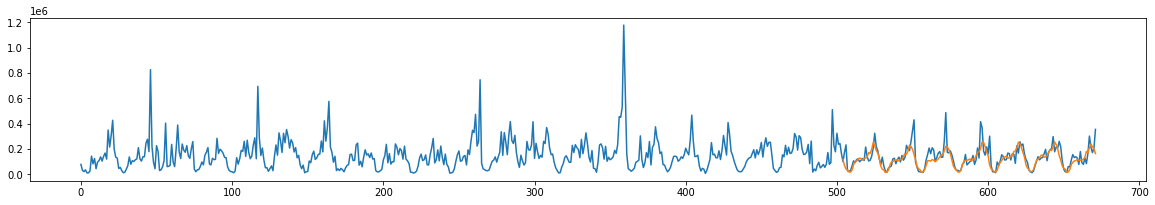

MAPE: tf.Tensor(34.51048, shape=(), dtype=float32)


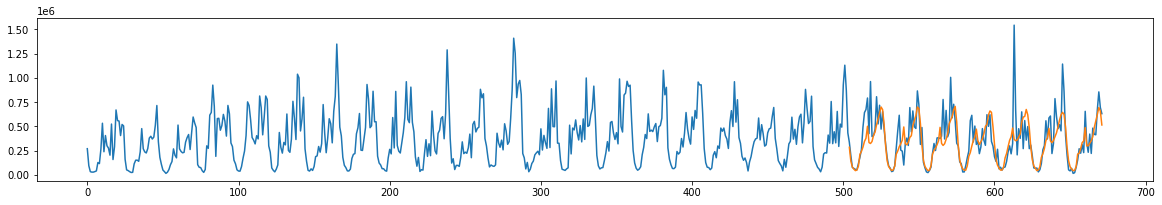

MAPE: tf.Tensor(35.32013, shape=(), dtype=float32)


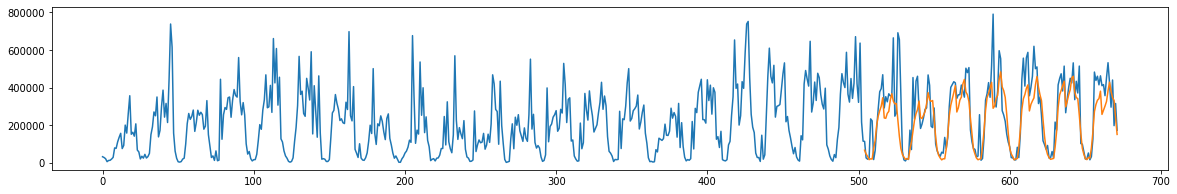

MAPE: tf.Tensor(32.67311, shape=(), dtype=float32)


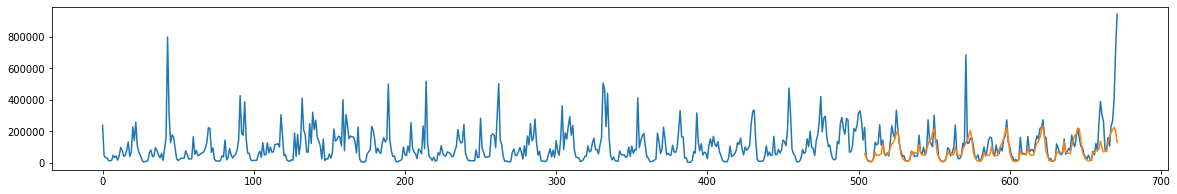

showing plots for kpi PDSCH
MAPE: tf.Tensor(9.918821, shape=(), dtype=float32)


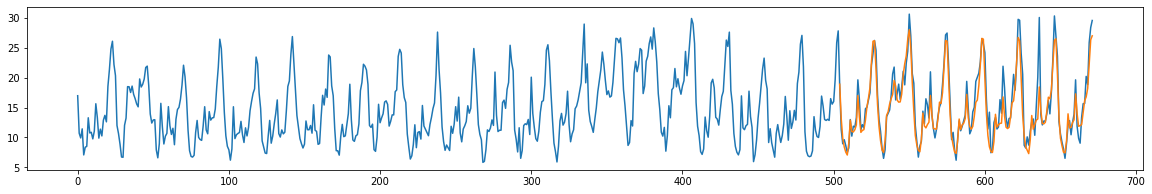

MAPE: tf.Tensor(6.6239157, shape=(), dtype=float32)


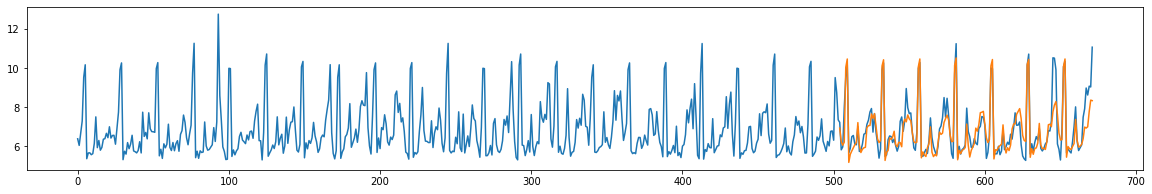

MAPE: tf.Tensor(6.6254244, shape=(), dtype=float32)


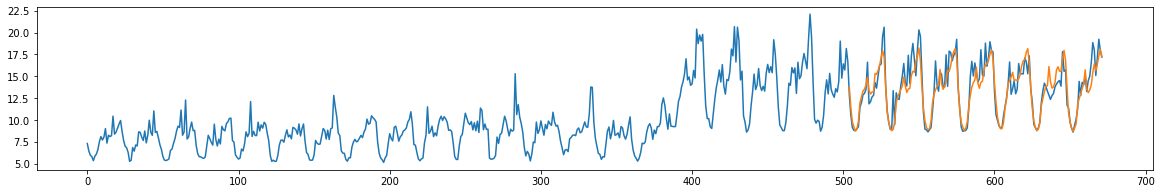

MAPE: tf.Tensor(17.806213, shape=(), dtype=float32)


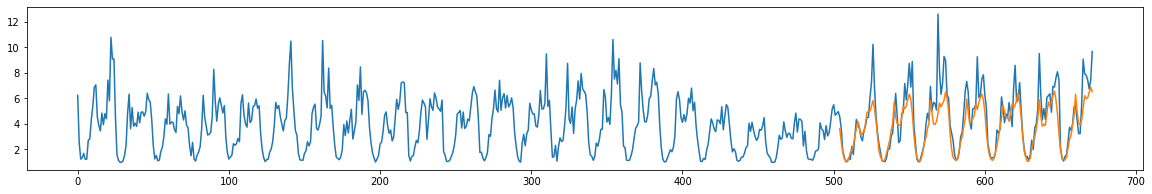

MAPE: tf.Tensor(24.468855, shape=(), dtype=float32)


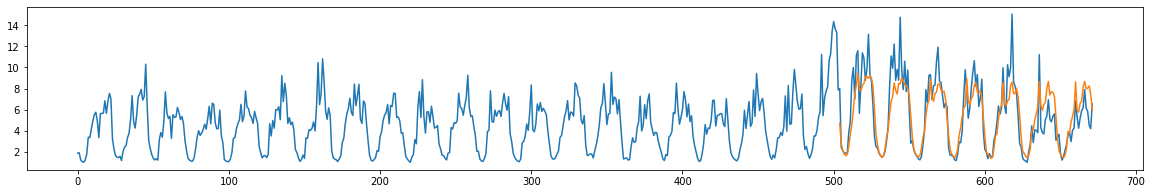

showing plots for kpi PUSCH
MAPE: tf.Tensor(17.219173, shape=(), dtype=float32)


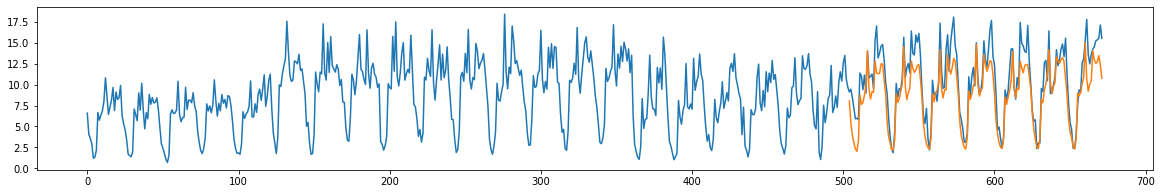

MAPE: tf.Tensor(13.056365, shape=(), dtype=float32)


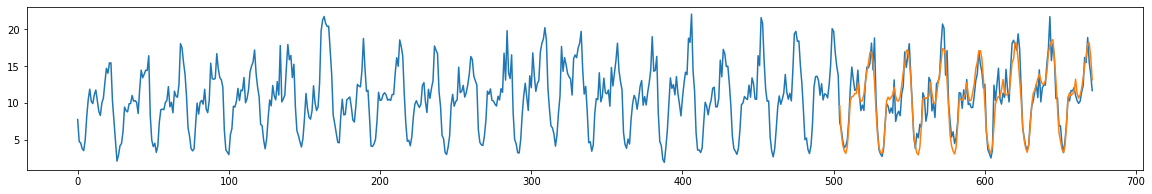

MAPE: tf.Tensor(15.041855, shape=(), dtype=float32)


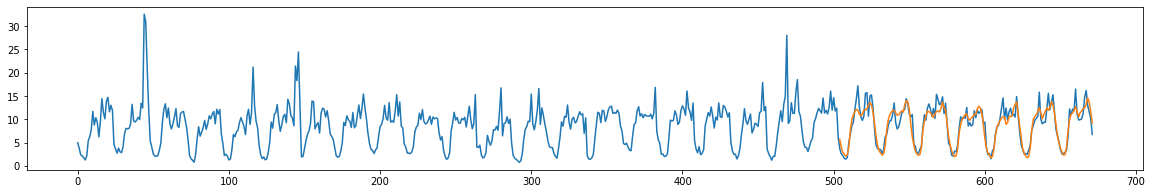

MAPE: tf.Tensor(29.485262, shape=(), dtype=float32)


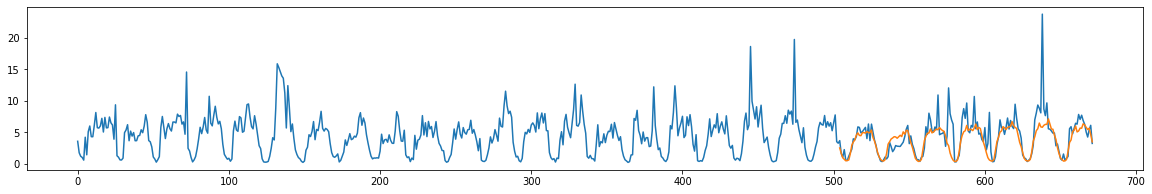

MAPE: tf.Tensor(16.303194, shape=(), dtype=float32)


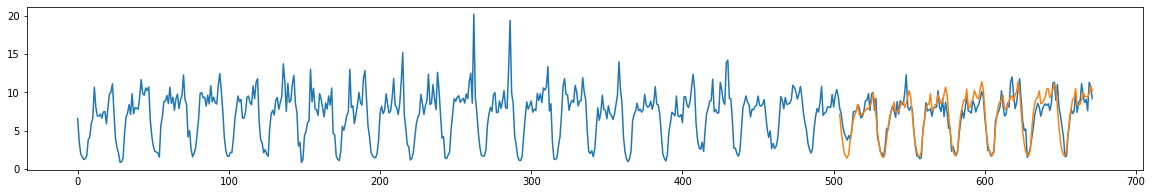

showing plots for kpi RRC
MAPE: tf.Tensor(11.300584, shape=(), dtype=float32)


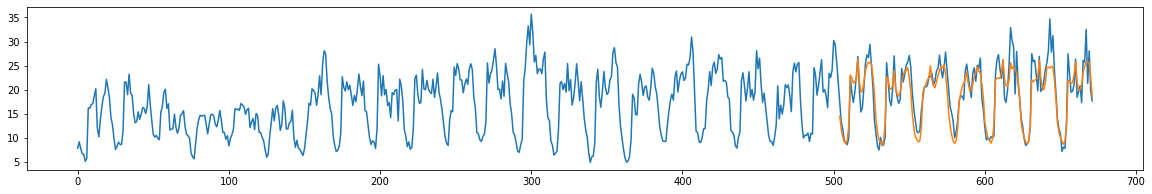

MAPE: tf.Tensor(15.628944, shape=(), dtype=float32)


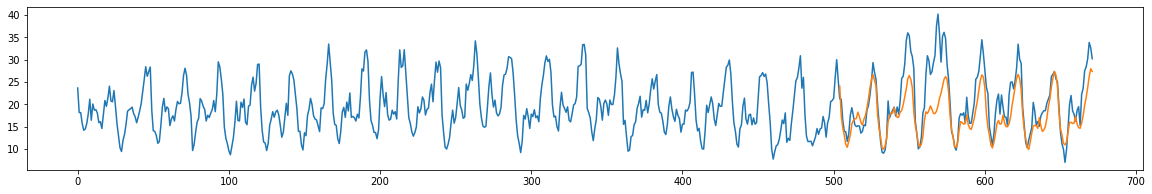

MAPE: tf.Tensor(11.511099, shape=(), dtype=float32)


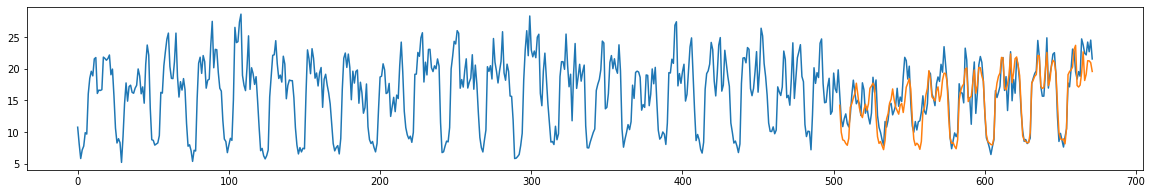

MAPE: tf.Tensor(4.013715, shape=(), dtype=float32)


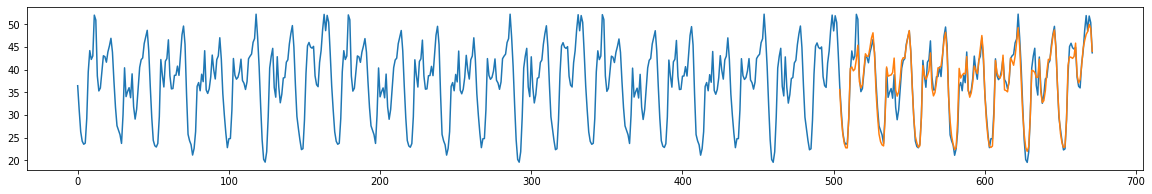

MAPE: tf.Tensor(14.855526, shape=(), dtype=float32)


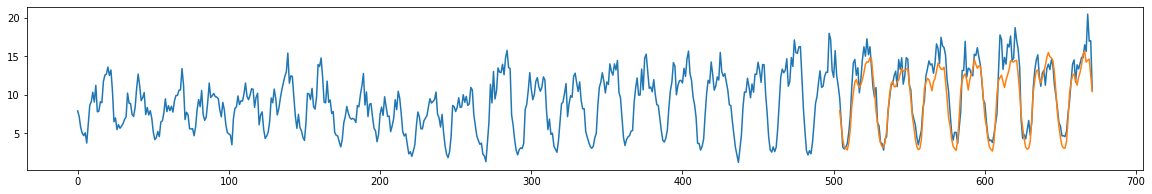

In [6]:
kpis = ['PDCCH', 'PDCPDL', 'PDCPUL', 'PDSCH', 'PUSCH', 'RRC']
for kpi in kpis:
    print('showing plots for kpi %s' % kpi)
    model = build_compile_model('mse', True)
    model.load_weights('models/5g_%s.h5' % kpi)
    plot_result(model, os.path.join(data_folder, '%s_%s' % ('5g', kpi)))